<a href="https://colab.research.google.com/github/christian-byrne/tucson-crime-models/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TODO

# Model 1 - Multi-Variable Linear Regression on GIS Data

**inputs**: GIS data
    - number of ... included in subsection
        - sidewalk
        - bicycle boulevards
        - landfill
        - fire station
        - bridge
        - crosswalk
        - streetcar route
        - streetcar stop
        - scenic route
        - streetlight
        - suntran bus stop
    - characteristics of subsection
        - race
            - column for each main race (or arbitrary groupings)
            - proportion of total  
        - mean income
        - mean education level
        - mean age

**output**: number of crimes / time legth of data set
            (aka crime frequency)


## Development Process

1. Create subsections
    - function that takes:
        - number subsections
            - type: int
            - width/height        
        - returns list of:
            -`bbox` (bounding box)
                - type: `tuple[Float]`
                - (lat_lower, lat_upper, long_lower, long_upper)

2. Accumulating data from each appropriate dataset such that it's like:
    
    | num sidewalks | .... | characteristics | ... | total number of crimes |

3. Data cleaning

4. Split data into training and testing sets

5. Determining best regression type:
    - For each regression type, hyperpamater tuning (determine optimal params)
        - Best subsets
            - particular subset of features
        - Lasso reg
            - best lambda/alpha (LARS)
        - Ridge reg
            - best lambda/alpha
    - Choose best regression type

6. Use given regression type to fit model

7. (hyperparamater tuning ?)

8. Evaluate model, reflect, make changes (repeat at step 5)
    - Choose some ...
        - arbitrary metric
        - significance level
        - baseline model
        - real model developed in actual scientific literature that does same thing
            - theres also a section of the report "Related Works" for this

# Model 2 - ...

want to:

- use other concepts from class like
    - qualitative outputs (logistic regression)
    - support vectors
    - ...

## Development Process

in general, similar to model 1 development process
- [ ] Use a more efficient method of joining data by geographic distance. E.g., connecting arrest incidents with nearest sidewalk. Current method could take hours with 50k arrests dataset.
- [ ] When making Folium maps (geographic maps with popup markers on them), use a plotting technique more appropriate to the data (refer to lecture slides). E.g., a heat map, contour plot, hexagon scatter plot.
- [ ] In the [datasets](https://github.com/christian-byrne/tucson-crime-models/tree/main/data), go to `infrastructure` folder, choose other infrastructure datasets (e.g., `streetlights`), and explore correlations in the same way it's been done for sidewalks in [Analzing correlation between distance to sidewalks and arrest frequency](https://colab.research.google.com/github/christian-byrne/tucson-crime-models/blob/main/main.ipynb#scrollTo=q-fOMfTsP1vG&line=1&uniqifier=1)
- ...Explore other trends in the data with other approaches. See these [suggestions given by LLM](https://github.com/christian-byrne/tucson-crime-models/blob/main/doc/correlation-discovery.md)


## Utils

### Configuration

In [1]:
from pathlib import Path
from typing import Union, Dict, Any


class Config:
    # Embedded configuration data
    _config_data: Dict[str, Any] = {
        "log_level": "DEBUG",
        "tucson_center_coordinates": [32.2226, -110.9747],
        "tucson_bounds": [-111, 32.0, -110.9747, 32.2226],
        "paths": {"visualizations": "visualizations"},
        "data_sources": {
            "arrests": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/crime/Tucson_Police_Arrests_-_2017_-_Open_Data.geojson",
            "sidewalks": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Sidewalks.geojson",
            "bicycle_boulevards": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Bicycle_Boulevards.geojson",
            "bridges": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Bridges_-_Open_Data.geojson",
            "crosswalks": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Crosswalks_-_Open_Data.geojson",
            "fire_stations": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Fire_Stations.geojson",
        },
    }

    # Root path for resolving paths
    ROOT_PATH: Path = Path(".").resolve()

    @staticmethod
    def get_proj_root(cls) -> Path:
        """Return the root path of the project."""
        return Config.ROOT_PATH

    def __getitem__(self, key: str) -> Any:
        """Get a configuration value by key, with KeyError if missing."""
        if key not in Config._config_data:
            msg = (
                f"Could not find key '{key}' in config."
                + f"Available keys: {list(Config._config_data.keys())}"
            )
            raise KeyError(msg)
        return Config._config_data[key]

    def __setitem__(self, key: str, value: Union[str, Path]) -> None:
        """Set a configuration value by key, converting Path to string if necessary."""
        if isinstance(value, Path):
            value = str(value.resolve())
        Config._config_data[key] = value

    @classmethod
    def get_all(cls) -> Dict[str, Any]:
        """Return the entire configuration data dictionary."""
        return cls._config_data

config = Config()

### Logging

In [2]:
import logging
from rich.logging import RichHandler


class Logger:
    def __init__(self, logger_name: str, level: int = logging.INFO):
        self.logger_base = logging.getLogger(logger_name)

        # Ensure no handlers are duplicated and set propagate to False
        self.logger_base.handlers.clear()
        self.logger_base.propagate = False

        rich_handler = RichHandler(
            rich_tracebacks=True, tracebacks_show_locals=True, markup=True
        )

        formatter = logging.Formatter("%(message)s")
        rich_handler.setFormatter(formatter)

        self.logger_base.addHandler(rich_handler)
        self.logger_base.setLevel(level)

    def __call__(self):
        return self.logger_base


logger = Logger("General", config["log_level"])()

### File Loading

In [3]:
import geopandas as gpd
import requests
from typing import Dict

# Dictionary to cache datasets in memory to prevent re-fetching in same session
_cache: Dict[str, gpd.GeoDataFrame] = {}


def load_dataset(dataset_name: str):
    # Check if the dataset is already cached
    if dataset_name in _cache:
        logger.info(f"Using cached data for {dataset_name}")
        return _cache[dataset_name]

    # Load the dataset from Config if not cached
    filepath = config["data_sources"][dataset_name]

    if filepath.startswith("http"):
        logger.info(f"Downloading dataset from {filepath}")
        response = requests.get(filepath)
        response.raise_for_status()
        with open(f"/tmp/{dataset_name}.geojson", "wb") as f:
            f.write(response.content)
        dataframe = gpd.read_file(f"/tmp/{dataset_name}.geojson")
    else:
        dataframe = gpd.read_file(filepath)

    logger.info(f"Loaded data from {filepath}")
    logger.debug(
        f"Columns in {filepath.split('/')[-1]}:\n{', '.join(dataframe.columns)}"
    )

    # Cache the loaded dataset
    _cache[dataset_name] = dataframe

    return dataframe

### Exploratory Data Analysis

#### Data Cleaning

##### Filter Geographic Information System (GIS) Data by Bounds

In [4]:
import folium
import geopandas as gpd
from shapely.geometry import box


def filter_by_bounds(data: gpd.GeoDataFrame, bounds: tuple) -> gpd.GeoDataFrame:
    """
    Filters the GeoDataFrame to include only points within the specified bounds.

    Parameters:
    data (GeoDataFrame): The data to filter.
    bounds (tuple): A tuple (minx, miny, maxx, maxy) defining the bounding box.

    Returns:
    GeoDataFrame: Filtered GeoDataFrame with points within the bounds.
    """
    logger.debug(f"Filtering data by bounds: {bounds}")
    bbox = box(*bounds)

    if len(data) == 0:
        logger.error("No data found in the input GeoDataFrame. Check the input data.")
        return data

    # Filter data by checking if geometry is within the bounding box
    filtered = data[data.geometry.within(bbox)]
    logger.info(f"Filtered out {len(data) - len(filtered)} rows outside the bounds. {len(filtered)} rows remaining.")

    if len(data) == len(filtered):
        logger.warning("All data is within the specified bounds. No data was filtered.")

    if len(filtered) == 0:
        logger.error(
            f"All data was filtered out. Check that the bounds {bounds} are correct."
        )

    return filtered

#### Data Visualization

##### Plot GIS Data on a Geographic Map

In [5]:
from typing import Optional


def create_map(
    data: gpd.GeoDataFrame,
    location: list = None,
    zoom_start: int = 12,
    popup_field: Optional[str] = None,
    save_path: Union[str, Path, None] = None,
):
    """
    Create a folium map with markers for each point in the input GeoDataFrame.

    Parameters:
    data (GeoDataFrame): The data to plot, must contain 'geometry' column.
    location (list): Latitude and longitude to center the map on. Default is Tucson, AZ.
    zoom_start (int): Initial zoom level for the map.
    popup_field (str, optional): Column name to use for the marker popups. If None, no popups.
    save_path (str or Path, optional): Path to save the generated map HTML file.

    Returns:
    folium.Map: A map with a marker for each point in data.
    """
    if len(data) == 0:
        logger.error("No data found in the input GeoDataFrame. Check the input data.")

    # Default location to Tucson, AZ if not provided
    location = location or [32.2226, -110.9747]

    logger.info(f"Creating map centered at {location} with zoom level {zoom_start}...")
    map_canvas = folium.Map(location=location, zoom_start=zoom_start)

    logger.debug("Filtering out rows with missing or non-Point geometry")
    data = data[data.geometry.notnull() & (data.geometry.type == "Point")]

    logger.info(f"Adding {len(data)} points to the map")
    for _, row in data.iterrows():
        # Retrieve the popup content if specified and available
        popup_text = (
            str(row[popup_field]) if popup_field and popup_field in row else None
        )
        folium.Marker([row.geometry.y, row.geometry.x], popup=popup_text).add_to(
            map_canvas
        )

    # Save map to HTML if save_path is specified
    if save_path:
        save_path = Path(save_path) if isinstance(save_path, str) else save_path
        map_canvas.save(save_path)
        logger.info(f"Map saved at {save_path}")

    # Display the map inline in the notebook
    # display(map_canvas) # NOTE: this happens automatically in collab

    return map_canvas

#### Data Joining

In [6]:
def join_data(
    left: gpd.GeoDataFrame,
    right: gpd.GeoDataFrame,
    left_key: str,
    right_key: str,
    how: str = "left",
) -> gpd.GeoDataFrame:
    """
    Join two GeoDataFrames based on a common key.

    Parameters:
    left (GeoDataFrame): The left GeoDataFrame to join.
    right (GeoDataFrame): The right GeoDataFrame to join.
    left_key (str): The column name to join on in the left GeoDataFrame.
    right_key (str): The column name to join on in the right GeoDataFrame.
    how (str): The type of join to perform. Default is 'left'.

    Returns:
    GeoDataFrame: A GeoDataFrame with the joined data.
    """
    logger.info(f"Joining data on {left_key} with {right_key} using {how} join")
    joined = left.merge(right, how=how, left_on=left_key, right_on=right_key)

    if len(joined) == 0:
        logger.error(
            f"No data was joined. Check that the keys {left_key} and {right_key} are correct."
        )

    return joined

##### Join GIS Data based on Distance Comparisons

In [7]:
# NOTE: This approach works well for moderately sized datasets but could become slow for very large ones. For large datasets, spatial indexing or more advanced spatial joins might be needed (e.g., using scipy’s cKDTree for faster nearest-neighbor searches).
def distance_join(
    main_gdf, ref_gdf, ref_col_name="nearest_id", distance_col_name="distance_to"
):
    """
    Adds a column to the main GeoDataFrame with the ID of the nearest feature
    from the reference GeoDataFrame.

    Parameters:
    main_gdf (GeoDataFrame): The main GeoDataFrame, typically with Point geometries (e.g., arrests data).
    ref_gdf (GeoDataFrame): The reference GeoDataFrame to find the nearest feature from (e.g., sidewalks).
    ref_col (str): The name of the new column in main_gdf to store the ID of the nearest feature.
    distance_col (str, optional): If provided, stores the distance to the nearest feature in this column.

    Returns:
    GeoDataFrame: The main GeoDataFrame with an added column for the nearest feature's ID.
    """
    # Ensure both GeoDataFrames are in the same CRS, convert to a metric CRS for distance calculation
    metric_crs = "EPSG:3857"
    main_gdf = main_gdf.to_crs(metric_crs)
    ref_gdf = ref_gdf.to_crs(metric_crs)

    # Prepare the new columns in main_gdf
    main_gdf[ref_col_name] = None
    if distance_col_name:
        main_gdf[distance_col_name] = None

    # For each geometry in main_gdf, find the closest geometry in ref_gdf
    for idx, main_geom in main_gdf.iterrows():
        # Find the nearest geometry in ref_gdf
        nearest_geom = ref_gdf.geometry.distance(main_geom.geometry).idxmin()

        # Add the ID of the nearest geometry (index) to the main_gdf
        main_gdf.at[idx, ref_col_name] = ref_gdf.at[
            nearest_geom, "OBJECTID"
        ]  # or another ID column in ref_gdf

        # Optionally, store the distance to the nearest feature
        if distance_col_name:
            distance = main_geom.geometry.distance(ref_gdf.at[nearest_geom, "geometry"])
            main_gdf.at[idx, distance_col_name] = distance

    # Reproject main_gdf back to the original CRS
    main_gdf = main_gdf.to_crs(ref_gdf.crs)

    return main_gdf

## Main

#### Load *Arrests* Data

In [8]:
arrests_data = load_dataset("arrests")

[12/01/24 01:16:03] INFO     Downloading dataset from                             ]8;id=475391;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=826798;file://<ipython-input-3-6edef7ff2aa9>#19\19]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/crime/Tucson_Police_Arre                                  
                             sts_-_2017_-_Open_Data.geojson                                                        

[12/01/24 01:16:26] INFO     Loaded data from                                     ]8;id=838457;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=483604;file://<ipython-input-3-6edef7ff2aa9>#28\28]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/crime/Tucson_Police_Arre                                  
                             sts_-_2017_-_Open_Data.geojson                                                        

                    DEBUG    Columns in                                           ]8;id=658799;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=68313;file://<ipython-input-3-6edef7ff2aa9>#29\29]8;;\
                             Tucson_Police_Arrests_-_2017_-_Open_Data.geojson:                                     
                             OBJECTID, X, Y, agency, arre_id, case_id, date_arr,                                   
                             time_arr, datetime_arr, MONTH_ARR, YEAR_ARR,                                          
                             DOW_ARR, TIME_ARRST, age, race, sex, ethnicity,                                       
                             arr_type, neighborhd, ADDRESS_PUBLIC, city, state,                                    
                             zip, arr_chrg, chrgdesc, chrg_cnt, fel_misd,                                          
                             chrg_seq, APPSTATE, LOC_STATUS, WARD, NHA_NAME,                                       
                             DIVISION, DIVISION_NO, DIVSECT, TRSQ, LOC_METHOD,                                     
                             geometry                                                                              

#### Clean Data

In [9]:
# Remove records with no geometry/location data
# (TODO: consult slides for other approaches to records with missing fields)
arrests_data = arrests_data[arrests_data.geometry.notnull()]

#### Truncate/Shrink Data for Fast Testing (Temporary)

In [10]:
# Restrict to just Tucson
arrests_data = filter_by_bounds(arrests_data, config["tucson_bounds"])

# Truncate
arrests_data = arrests_data.head(1000)

                    DEBUG    Filtering data by bounds: [-111, 32.0, -110.9747,    ]8;id=846696;file://<ipython-input-4-628a12a4daad>\<ipython-input-4-628a12a4daad>]8;;\:]8;id=668985;file://<ipython-input-4-628a12a4daad>#17\17]8;;\
                             32.2226]                                                                              

                    INFO     Filtered out 56262 rows outside the bounds. 6694     ]8;id=402065;file://<ipython-input-4-628a12a4daad>\<ipython-input-4-628a12a4daad>]8;;\:]8;id=11483;file://<ipython-input-4-628a12a4daad>#26\26]8;;\
                             rows remaining.                                                                       

#### Visualize Arrests Data

In [11]:
create_map(arrests_data, popup_field="ArrestChargeandDescription")

                    INFO     Creating map centered at [32.2226, -110.9747] with   ]8;id=202649;file://<ipython-input-5-e960f8a72a7f>\<ipython-input-5-e960f8a72a7f>]8;;\:]8;id=164238;file://<ipython-input-5-e960f8a72a7f>#30\30]8;;\
                             zoom level 12...                                                                      

                    DEBUG    Filtering out rows with missing or non-Point         ]8;id=432721;file://<ipython-input-5-e960f8a72a7f>\<ipython-input-5-e960f8a72a7f>]8;;\:]8;id=692991;file://<ipython-input-5-e960f8a72a7f>#33\33]8;;\
                             geometry                                                                              

                    INFO     Adding 1000 points to the map                        ]8;id=518539;file://<ipython-input-5-e960f8a72a7f>\<ipython-input-5-e960f8a72a7f>]8;;\:]8;id=861400;file://<ipython-input-5-e960f8a72a7f>#36\36]8;;\

#### Load *Sidewalks* Data

In [12]:
sidewalks_data = load_dataset("sidewalks")

[12/01/24 01:16:27] INFO     Downloading dataset from                             ]8;id=646757;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=564979;file://<ipython-input-3-6edef7ff2aa9>#19\19]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Sidewalks                                  
                             .geojson                                                                              

[12/01/24 01:16:31] INFO     Loaded data from                                     ]8;id=440885;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=158184;file://<ipython-input-3-6edef7ff2aa9>#28\28]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Sidewalks                                  
                             .geojson                                                                              

                    DEBUG    Columns in Sidewalks.geojson:                        ]8;id=589224;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=634605;file://<ipython-input-3-6edef7ff2aa9>#29\29]8;;\
                             OBJECTID, DATASOURCE, ShapeSTLength, geometry                                         

#### Add `distance_to_nearest_sidewalk` to Arrests Data

In [13]:
arrests_data = distance_join(
    arrests_data,
    sidewalks_data,
    ref_col_name="nearest_sidewalk_id",
    distance_col_name="distance_to_nearest_sidewalk",
)

#### Analyze Correlation between Arrests Frequency and `distance_to_nearest_sidewalk`

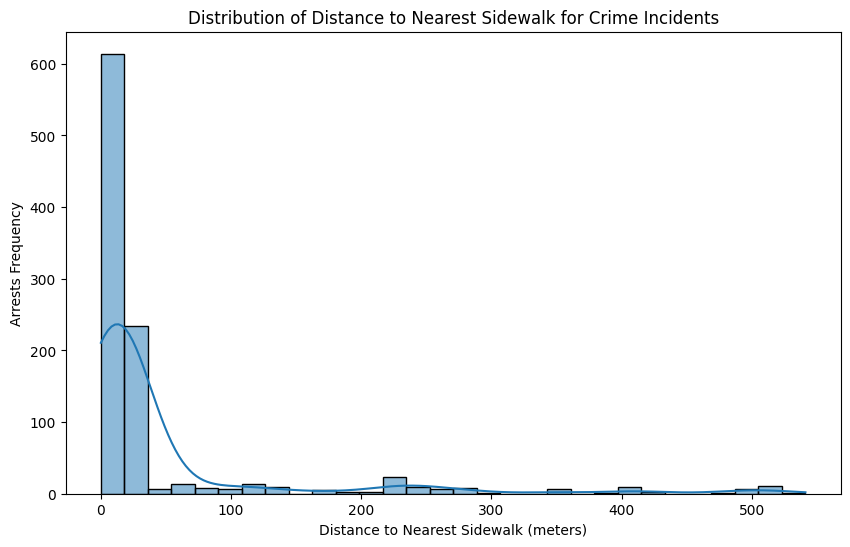

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(arrests_data["distance_to_nearest_sidewalk"], kde=True, bins=30)
plt.xlabel("Distance to Nearest Sidewalk (meters)")
plt.ylabel("Arrests Frequency")
plt.title("Distribution of Distance to Nearest Sidewalk for Crime Incidents")
plt.show()

In [15]:
import folium

TUCSON_BOUNDS = [-111, 32.0, -110.9747, 32.2226]

def create_subsections(number, bbox):
    """
    Params:
    number: int - number of subsections
    bbox: tuple[Float] - (min_x, min_y, max_x, max_y) - bounding box of the area to be divided

    Returns:
    subsections: list[tuple[Float]] -
      list of tuples (min_x, min_y, max_x, max_y) representing the subsections of the area

    """
    min_x, min_y, max_x, max_y = bbox
    x_diff = (max_x - min_x) / number
    y_diff = (max_y - min_y) / number

    subsections = []
    for i in range(number):
        for j in range(number):
            subsections.append(
                (
                    min_x + i * x_diff,
                    min_y + j * y_diff,
                    min_x + (i + 1) * x_diff,
                    min_y + (j + 1) * y_diff,
                )
            )

    return subsections

# Adjusting the visualization function for bounding box interpretation
def visualize_subsections_on_map(subsections, center_coordinates, zoom_start=12):
    """
    Visualize the geographical subsections on a Folium map.

    Parameters:
    subsections: list[tuple[float]] - List of bounding boxes for subsections in (min_x, min_y, max_x, max_y) format.
    center_coordinates: list[float] - Coordinates to center the map on.
    zoom_start: int - Initial zoom level for the map.

    Returns:
    folium.Map: The Folium map with subsections visualized.
    """
    # Create a Folium map centered at the given location
    folium_map = folium.Map(location=center_coordinates, zoom_start=zoom_start)

    # Add rectangles for each subsection
    for subsection in subsections:
        # bounds = [[min_y, min_x], [max_y, max_x]]
        bounds = [[subsection[1], subsection[0]], [subsection[3], subsection[2]]]
        folium.Rectangle(bounds, color="blue", fill=True, fill_opacity=0.2).add_to(folium_map)

    return folium_map

# Define the Tucson center coordinates and bounds
tucson_center_coordinates = [32.2226, -110.9747]

# Generate subsections
test_sections = create_subsections(6, TUCSON_BOUNDS)

# Visualize on map
map_with_subsections = visualize_subsections_on_map(test_sections, tucson_center_coordinates)
map_with_subsections


In [16]:
import pandas as pd

CV = 5
SCORING = "r2"


def count_objects_in_subsection(objects, subsection):
    """
    Accept list of locations of objects (sidewalk, landfill, crosswalk, etc.) and a subsection area, return the number of objects in the subsection.

    Params:
    objects: GeoDataFrame - locations of objects
    subsection: tuple[Float] - (min_x, min_y, max_x, max_y) - bounding box of the subsection

    Returns:
    count: int - number of objects in the subsection
    """
    subsection_box = box(*subsection)

    # Filter objects within subsection
    # Use `geometry.within` to check if the object is fully contained within the subsection
    # Use `geometry.intersects` to check if geometries share any part of their space
    # Use `geometry.overlaps` to check if geometries overlap, but it excludes cases where one geometry entirely contains or is entirely contained by the other
    objects_in_subsection = objects[objects.geometry.intersects(subsection_box)]

    return len(objects_in_subsection)



#### Create Infrastructure Features

In [17]:
print(f"Number of subsections: {len(test_sections)}")

# Inputs: For all the infrastructure features, load the respective dataset and count the number of objects in each subsection
x_feature_names = [
    "bicycle_boulevards",
    "sidewalks",
    "bridges",
    "crosswalks",
    "fire_stations",
]
rows = []
for feature in x_feature_names:
    feature_dataset = load_dataset(feature)
    row = [
        count_objects_in_subsection(feature_dataset, subsection)
        for subsection in test_sections
    ]
    print(f"{feature} counts in each subsection: {row}")
    rows.append(row)

# Output: Load the arrests data and count the number of arrests in each subsection
arrests_data = load_dataset("arrests")
arrests_counts = [
    count_objects_in_subsection(arrests_data, subsection)
    for subsection in test_sections
]
print(f"Arrests counts in each subsection: {arrests_counts}")

# Add the arrests counts to the rows
rows.append(arrests_counts)

Number of subsections: 36


[12/01/24 01:17:25] INFO     Downloading dataset from                             ]8;id=361656;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=98452;file://<ipython-input-3-6edef7ff2aa9>#19\19]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Bicycle_B                                  
                             oulevards.geojson                                                                     

                    INFO     Loaded data from                                     ]8;id=825140;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=495061;file://<ipython-input-3-6edef7ff2aa9>#28\28]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Bicycle_B                                  
                             oulevards.geojson                                                                     

                    DEBUG    Columns in Bicycle_Boulevards.geojson:               ]8;id=625141;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=945077;file://<ipython-input-3-6edef7ff2aa9>#29\29]8;;\
                             OBJECTID, Location, ProjectName, StatusCode,                                          
                             Category, Treatment, Lane_Miles, Length_ft, Ward,                                     
                             Location_Desc, Type, ProjectID, Status,                                               
                             PercentComplete, FY_Planned, UCC_Update, NextUCC,                                     
                             PM_Name, PM_Backup, Fund, Federal_Fund, Consultant,                                   
                             DES_Start, LastSubmitPercent, LastSubmitDate,                                         
                             NextSubmitPercent, NextSubmitDate, DES_Finish,                                        
                             UTILRelocDeadline, Contractor, CON_Advert, CON_NTP,                                   
                             CON_Finish, Notes, Photo, Description, PM_Email,                                      
                             PM_Phone, Backup_Email, Backup_Phone, DATASOURCE,                                     
                             Paved, Con_Finish_Date, ProjectStatus,                                                
                             Con_Begin_Date, Design_Begin_Date,                                                    
                             FY_ConstructionBegin, FY_DesignBegin, DesignBegin,                                    
                             ConstructionBegin, DesignFinish, ConstructionFinish,                                  
                             UpdateSummary, URL, LocationStatus, ART_ELIGIBLE,                                     
                             ART_BUNDLE, Fed_Fund, RTA_Fund, County_Fund,                                          
                             HURF_Fund, PublicStatus, Dept, IF_Fund, GlobalID,                                     
                             SHAPESTLength, geometry                                                               

bicycle_boulevards counts in each subsection: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 3, 0, 0, 0, 3, 3, 2, 0, 0, 0, 2, 3, 2]


                    INFO     Using cached data for sidewalks                      ]8;id=874707;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=541480;file://<ipython-input-3-6edef7ff2aa9>#12\12]8;;\

sidewalks counts in each subsection: [0, 0, 0, 320, 702, 303, 0, 0, 0, 34, 323, 106, 0, 0, 0, 19, 71, 131, 0, 0, 0, 185, 130, 133, 0, 0, 0, 336, 242, 49, 0, 0, 0, 1943, 372, 202]


[12/01/24 01:17:26] INFO     Downloading dataset from                             ]8;id=936767;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=546685;file://<ipython-input-3-6edef7ff2aa9>#19\19]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Bridges_-                                  
                             _Open_Data.geojson                                                                    

                    INFO     Loaded data from                                     ]8;id=837339;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=216341;file://<ipython-input-3-6edef7ff2aa9>#28\28]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Bridges_-                                  
                             _Open_Data.geojson                                                                    

                    DEBUG    Columns in Bridges_-_Open_Data.geojson:              ]8;id=110572;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=87183;file://<ipython-input-3-6edef7ff2aa9>#29\29]8;;\
                             OBJECTID, CartegraphID, LocalID, LocalName,                                           
                             STREETNAME, FeaturEsCrossed, Location, YearBuilt,                                     
                             SufficiencyRating, Status, StateName, LanesON_Under,                                  
                             BridgeMedian, HistoricalSignificance,                                                 
                             DeckStructureType, DeckWearingSurface, DeckMembrane,                                  
                             DeckProtection, DeckWearingThickness,                                                 
                             MaximumSpanLength, StructureLength,                                                   
                             BridgeWidthCurbtoCurb, OnStructureServiceType,                                        
                             UnderStructureServiceType, StructureMaterial,                                         
                             StructureType, NumberofMainSpans, InspectionDate,                                     
                             ScourCriticalRating, DesignLoad, LoadRatingStatus,                                    
                             PostingRequired, CulvertBarrelHeight, CulvertLength,                                  
                             CulvertFillHeight, Lat, Lon, DATASOURCE, Retired,                                     
                             geometry                                                                              

bridges counts in each subsection: [0, 0, 0, 2, 0, 3, 0, 0, 0, 2, 1, 3, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 3]


                    INFO     Downloading dataset from                             ]8;id=619243;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=292623;file://<ipython-input-3-6edef7ff2aa9>#19\19]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Crosswalk                                  
                             s_-_Open_Data.geojson                                                                 

                    INFO     Loaded data from                                     ]8;id=469062;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=275481;file://<ipython-input-3-6edef7ff2aa9>#28\28]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Crosswalk                                  
                             s_-_Open_Data.geojson                                                                 

                    DEBUG    Columns in Crosswalks_-_Open_Data.geojson:           ]8;id=925240;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=668410;file://<ipython-input-3-6edef7ff2aa9>#29\29]8;;\
                             CROSSWALK_TYPE, GUARDED, HIGH_VISIBILITY,                                             
                             SIGNALIZED, GlobalID, OBJECTID, DATASOURCE,                                           
                             ShapeSTLength, geometry                                                               

crosswalks counts in each subsection: [0, 0, 0, 11, 4, 9, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 4, 3, 0, 0, 0, 8, 7, 1, 0, 0, 0, 9, 8, 15, 0, 0, 0, 20, 25, 19]


                    INFO     Downloading dataset from                             ]8;id=206326;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=182083;file://<ipython-input-3-6edef7ff2aa9>#19\19]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Fire_Stat                                  
                             ions.geojson                                                                          

                    INFO     Loaded data from                                     ]8;id=916903;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=823372;file://<ipython-input-3-6edef7ff2aa9>#28\28]8;;\
                             https://raw.githubusercontent.com/christian-byrne/tu                                  
                             cson-crime-models/main/data/infrastructure/Fire_Stat                                  
                             ions.geojson                                                                          

                    DEBUG    Columns in Fire_Stations.geojson:                    ]8;id=67494;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=242692;file://<ipython-input-3-6edef7ff2aa9>#29\29]8;;\
                             OBJECTID, STA_NUM, DISTRICT, ADDRESS, URL,                                            
                             DATASOURCE, geometry                                                                  

fire_stations counts in each subsection: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


                    INFO     Using cached data for arrests                        ]8;id=493965;file://<ipython-input-3-6edef7ff2aa9>\<ipython-input-3-6edef7ff2aa9>]8;;\:]8;id=180875;file://<ipython-input-3-6edef7ff2aa9>#12\12]8;;\

Arrests counts in each subsection: [0, 0, 0, 162, 189, 197, 0, 0, 0, 20, 219, 1323, 0, 0, 0, 28, 399, 126, 0, 0, 0, 71, 103, 155, 0, 0, 0, 208, 245, 1293, 0, 0, 0, 378, 1284, 294]


##### Visualize each Infrastructure Feature on Map inside Subsections (Items)

In [18]:

def visualize_objects_in_subsection(
    objects, subsection, center=[32.2226, -110.9747]  # tuscon center coordinates
):
    """
    Accept list of locations of objects (sidewalk, landfill, crosswalk, etc.) and a list of subsections. For each object, if it is in one of the subsections, plot the object on a folium map.

    Params:
    objects: GeoDataFrame - locations of objects
    subsections: list[tuple[Float]] - List of bounding boxes for subsections in (min_x, min_y, max_x, max_y) format.

    Returns:
    folium.Map: The Folium map with objects visualized.

    """
    # Create a Folium map centered at the given location
    folium_map = folium.Map(location=tucson_center_coordinates, zoom_start=12)

    # Add rectangles for each subsection
    for subsection in test_sections:
        bounds = [[subsection[1], subsection[0]], [subsection[3], subsection[2]]]
        folium.Rectangle(bounds, color="blue", fill=True, fill_opacity=0.2).add_to(
            folium_map
        )

    # Add objects within subsections
    for _, obj in objects.iterrows():
        for subsection in test_sections:
            subsection_box = box(*subsection)

            # Use `geometry.within` to check if the object is fully contained within the subsection
            # Use `geometry.intersects` to check if geometries share any part of their space
            # Use `geometry.overlaps` to check if geometries overlap, but it excludes cases where one geometry entirely contains or is entirely contained by the other
            if obj.geometry.intersects(subsection_box):
                if obj.geometry.geom_type == "Point":
                    folium.Marker(
                        [obj.geometry.y, obj.geometry.x], popup=obj["OBJECTID"]
                    ).add_to(folium_map)
                elif obj.geometry.geom_type == "LineString":
                    coords = [(point[1], point[0]) for point in obj.geometry.coords]
                    folium.PolyLine(
                        coords, color="red", weight=2.5, opacity=0.8
                    ).add_to(folium_map)

    return folium_map

# Visualize the sidewalks in each subsection
# folium_map = visualize_objects_in_subsection(sidewalks_data, test_sections)

# Display the map
# folium_map

#### Combine Data into a Single DataFrame

In [19]:
num_records = len(rows[0])

# Create a DataFrame for the transformed data
# Create a DataFrame where subsections are rows and features are columns
counts_df = pd.DataFrame(
    data=zip(*rows),  # Transpose the rows to make subsections as rows
    columns=x_feature_names + ["Arrests"],  # Features as column names
    index=[f"Subsection {i}" for i in range(1, num_records + 1)],  # Subsections as row indices
)

#### Split Data into Training and Testing Sets

In [20]:
# Create train/test split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# Use 80% of the data for training and 20% for testing
train, test = train_test_split(counts_df, test_size=0.2, random_state=42)

#### Data Cleaning

##### Normalize Data

In [21]:
# Use sklear.preprocessing.StandardScaler to scale (normalize) the data
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler().fit(train[x_feature_names])  # Scale feature columns

# scaling is done after train/test split to avoid data leakage
# Normalize only the feature columns in the train/test sets
train[x_feature_names] = scaler.transform(train[x_feature_names])
test[x_feature_names] = scaler.transform(test[x_feature_names])

# Display the scaled training data
print("Training data after scaling:")
print(train.head())
print("\nTesting data after scaling:")
print(test.head())

Training data after scaling:
               bicycle_boulevards  sidewalks   bridges  crosswalks  \
Subsection 9            -0.668437  -0.486048 -0.775880   -0.639325   
Subsection 18            0.222812  -0.139397  1.199088   -0.180322   
Subsection 10           -0.668437  -0.396078  1.199088   -0.639325   
Subsection 35            2.005312   0.498334  0.211604    3.185697   
Subsection 1            -0.668437  -0.486048 -0.775880   -0.639325   

               fire_stations  Arrests  
Subsection 9        -0.19245        0  
Subsection 18       -0.19245      126  
Subsection 10       -0.19245       20  
Subsection 35       -0.19245     1284  
Subsection 1        -0.19245        0  

Testing data after scaling:
               bicycle_boulevards  sidewalks   bridges  crosswalks  \
Subsection 36            1.114062   0.048482  2.186571    2.267692   
Subsection 14           -0.668437  -0.486048 -0.775880   -0.639325   
Subsection 27           -0.668437  -0.486048 -0.775880   -0.639325   
S

##### Remove Outliers

... todo ...

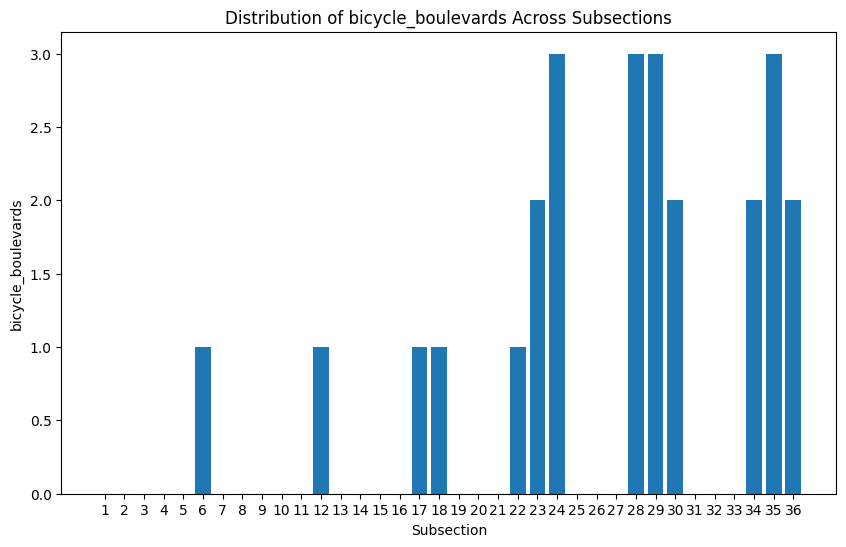

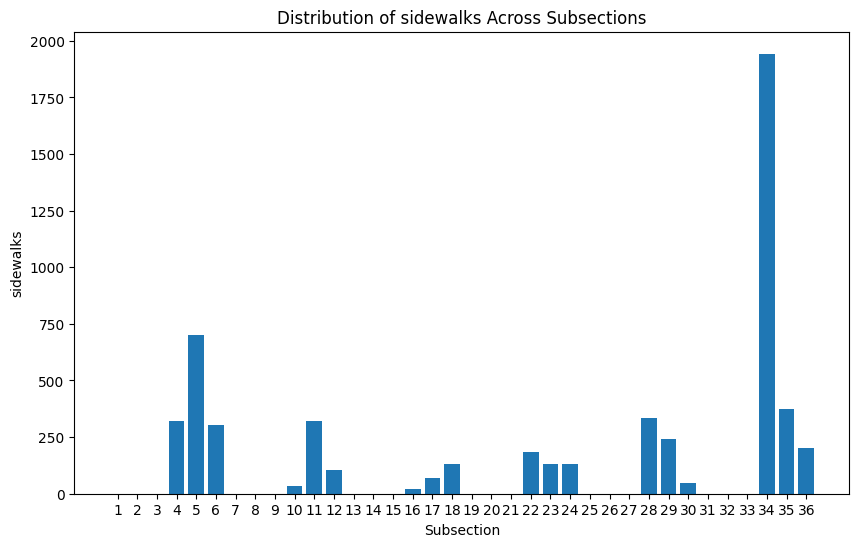

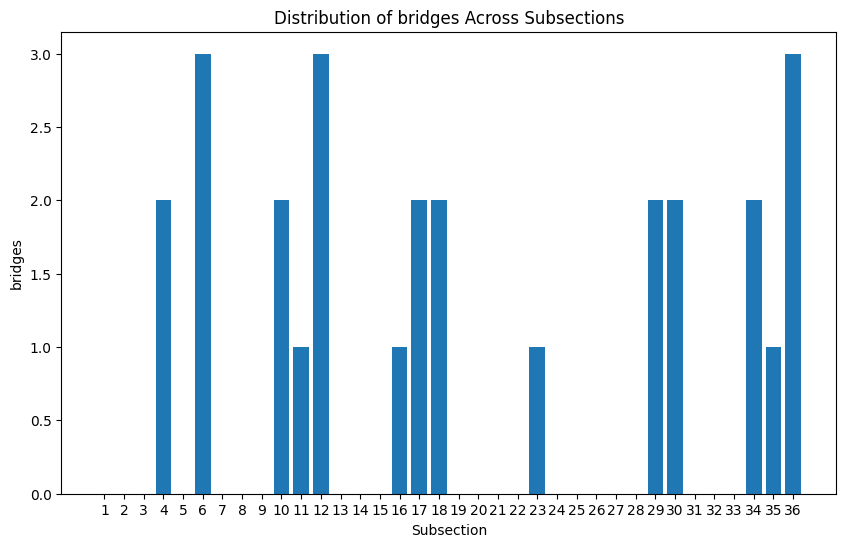

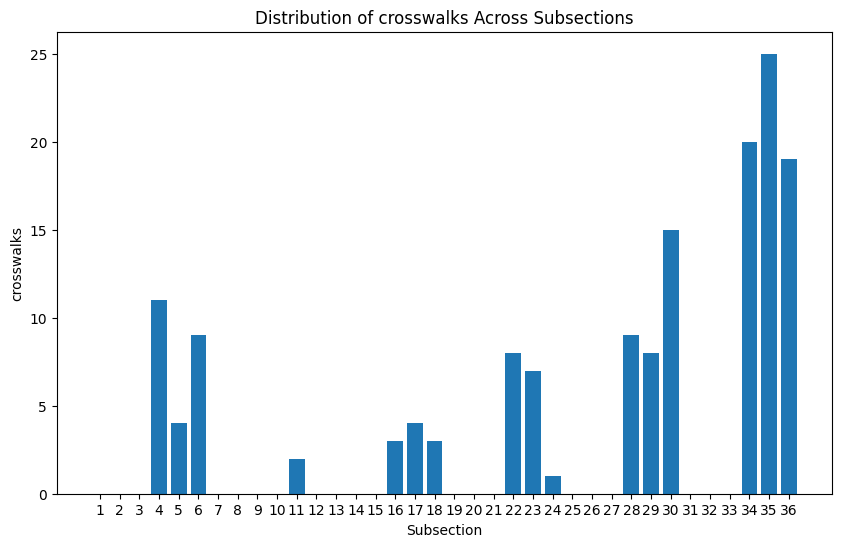

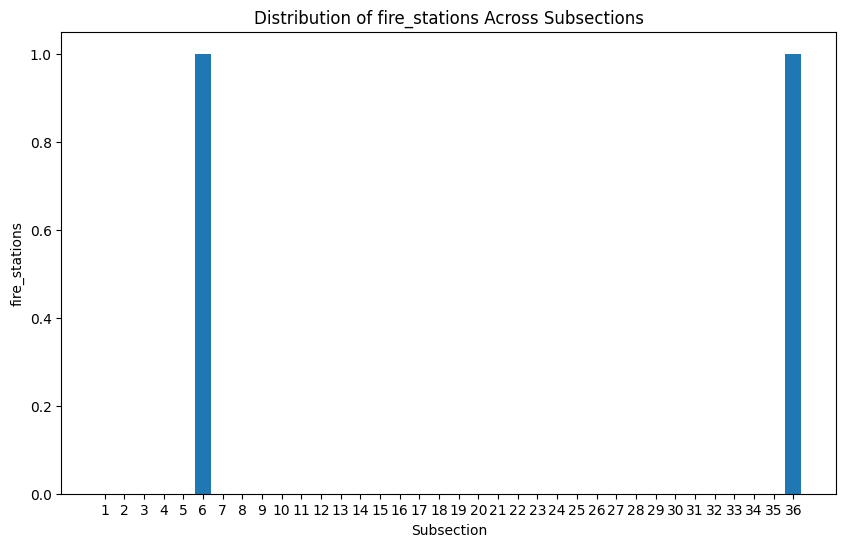

In [40]:
import matplotlib
import matplotlib.pyplot as plt

def visualize_single_feature(feature, subsections):
  '''
  Given a feature and its subsections, visualize the data as a bar graph
  Params:
    feature: str - name of the feature to visualize
    subsections: a list of subsections with the feature present
  Returns:
    None
  '''
  # Create a bar graph with the size of 10,6
  plt.figure(figsize=(10, 6))

  # Plot the data as a bar graph
  plt.bar(range(len(subsections)), subsections)

  # Set x-axis labels
  plt.xticks(range(len(subsections)), [f"{i}" for i in range(1, len(subsections) + 1)])


  # Set labels and title
  plt.xlabel('Subsection')
  plt.ylabel(feature)
  plt.title(f'Distribution of {feature} Across Subsections')


  # Show the plot
  plt.show()

# a full column corresponding to the feature
for feature in x_feature_names:
  x = counts_df[feature].tolist()
  visualize_single_feature(feature, x)

##### Remove Missing or Duplicate Data

... todo ...


##### Other Data Cleaning Tasks

... todo ...

#### Split Data into Input ($X$) and Output ($y$) Data

In [ ]:
# Split into X and y
X_train, y_train = train[x_feature_names], train["Arrests"]
X_test, y_test = test[x_feature_names], test["Arrests"]

#### Best Subsets

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Create function to find subsets of features
from itertools import combinations

def find_subsets(features, max_length):
    """
    Find all possible subsets of features up to a given maximum length.

    Parameters:
    features (list): The list of features to find subsets from.
    max_length (int): The maximum length of subsets to consider.

    Returns:
    set: A set of tuples containing subsets of features.
    """
    subsets = set()
    for L in range(1, max_length + 1):
        for subset in combinations(features, L):
            subsets.add(subset)
    return subsets

lr = LinearRegression()
subset_sizes = []
r2_means_subsets = []
for subset_size in range(1, len(x_feature_names) + 1):
    # Find all possible subsets of features for the current size
    subsets = find_subsets(x_feature_names, subset_size)

    # Calculate the mean R^2 score for each subset
    for subset in subsets:
        mean_r2 = cross_val_score(
            lr, X_train[list(subset)], y_train, cv=CV, scoring=SCORING
        ).mean()
        subset_sizes.append(subset_size)
        r2_means_subsets.append((mean_r2, subset))

# plot the R-squared values vs. subset size
plt.scatter(subset_sizes, [r2 for r2, _ in r2_means_subsets], alpha=0.8, s=7)
plt.xlabel("Subset Size (Num. Features)")
plt.ylabel("R-squared")
plt.title("R-squared vs. Subset Size")

# report the best-performing subset of features
best_r2_subset_2, best_feature_combo = sorted(r2_means_subsets, key=lambda x: -x[0])[0]
print(
    f"Best-performing set of features: {best_feature_combo} (R-squared = {best_r2_subset_2})"
)

#### Ridge Regression

In [ ]:
# Ridge Regression
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import numpy as np

# Create a range of 50 alpha values spaced logarithmically in the range [10^-1, 10^3]
domain = np.logspace(-1, 3, 50)

# find the best alpha value across domain
r2_means_ridge, r2_stds_ridge = [], []
for alpha in domain:
    reg = linear_model.Ridge(alpha=alpha)
    r2_vals = cross_val_score(reg, X_train, y_train, scoring=SCORING, cv=CV)
    r2_means_ridge.append(r2_vals.mean())
    r2_stds_ridge.append(r2_vals.std())

# plot the R-squared values
plt.errorbar(domain, r2_means_ridge, yerr=r2_stds_ridge, fmt="-", capsize=3)
plt.xscale("log")
plt.title("Ridge Regression - R² vs α")
plt.xlabel("α (log scale)")
plt.ylabel("Average R²")

# report the best R-squared value and the corresponding alpha
best_r2_ridge = np.max(r2_means_ridge)
best_alpha_ridge = domain[np.argmax(r2_means_ridge)]
print(f"Best R²: {best_r2_ridge:.3f}, Best α: {best_alpha_ridge:.3f}")